# FiniteHilbertTransform example

This example uses the FiniteHilbertTransform.jl package to compute the location of modes in a homogeneous plasma: see Section 5.2.4 of Binney and Tremaine (2008), or Appendix E of Fouvry & Prunet (2022).

In [1]:
using Pkg
Pkg.add("Plots")
using Plots


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Code/FiniteHilbertTransform/Project.toml`
  No Changes to `~/Code/FiniteHilbertTransform/Manifest.toml`


In [2]:
import FiniteHilbertTransform
Pkg.precompile()

Now set the parameters. These defaults will produce the image in the example folder.

In [3]:

# how many Legendre knots?
Ku  = 200

# stability parameter: 0<q<1 ensures stability
qself = 0.5

# what is the maximum velocity for integration?
xmax = 20.0

# parameters for the real frequencies in the grid
Omegamin = -4.0
Omegamax = 4.0
nOmega   = 800

# parameters for the imaginary frequencies in the grid
Etamin = -3.0
Etamax = 3.0
nEta= 400



400

Next, set the functions that we will integrate, as well as the framework within which to do the integration.

In [4]:
"""
Calculate the G(u) function for a plasma: here, a simple Maxwellian.
see Equation E5 of Fouvry & Prunet (2022)

# Arguments
- `u::Float64`: The velocity parameter.
- `qSELF::Float64`: A parameter specific to the plasma.
- `xmax::Float64`: The maximum value of x.

# Returns
- `Float64`: The value of G(u) for the given parameters.

# Example
```julia
get_G(1.0, 0.5, 10.0)
```
"""
function get_G(u::Float64,qSELF::Float64,xmax::Float64)
    x = u*xmax # Value of the velocity
    return qSELF/(sqrt(pi))*x*exp(-x^(2)) 
end



"""
Pre-compute the values of G(u) for the specified plasma model.

# Arguments
- `uNodes::Vector{Float64}`: Vector of nodes for which G(u) needs to be computed.
- `qSELF::Float64`: A parameter specific to the plasma model.
- `xmax::Float64`: The maximum value of x.

# Returns
- `tabG::Vector{Float64}`: Vector containing pre-computed values of G(u) for each node.

# Example
```julia
CGFuncPlasma([0.1, 0.2, 0.3], 0.5, 10.0)
```
"""
function CGFuncPlasma(uNodes::Vector{Float64}, qSELF::Float64, xmax::Float64)
    K_u = size(uNodes, 1)
    tabG = zeros(Float64, K_u)

    # Loop over the nodes
    Threads.@threads for i = 1:K_u
        # Current node position
        u_i = uNodes[i]

        # Compute the value of G[u_i]
        tabG[i] = get_G(u_i, qSELF, xmax)
    end

    return tabG
end


"""
Compute the values of I-Xi(omg) for a given complex frequency.

# Arguments
- `omg::Complex{Float64}`: Complex frequency.
- `taba::Vector{Float64}`: Vector of coefficients a_k(u).
- `xmax::Float64`: Maximum value of x.
- `FHT::FiniteHilbertTransform.AbstractFHT`: AbstractFHT structure.

# Returns
- `IminusXi::Complex{Float64}`: Value of I-Xi(omg).

# Example
```julia
GetLegendreIminusXiPlasma(1.0 + 1.0im, taba, 10.0, FHT)
```
"""
function GetLegendreIminusXiPlasma(omg::Complex{Float64},
                                   taba::Vector{Float64},
                                   xmax::Float64,
                                   FHT::FiniteHilbertTransform.AbstractFHT)


    # Rescale the COMPLEX frequency
    K_u = size(taba,1)

    varpi = omg/xmax

    # compute the Hilbert-transformed Legendre functions
    FiniteHilbertTransform.GettabD!(varpi,FHT)

    xi = 0.0 + 0.0*im # Initialise xi

    # loop over the Legendre functions
    for k=1:(K_u)

        # add the contribution
        xi += taba[k]*FHT.tabDLeg[k]
    end

    # compute 1.0 - xi
    IminusXi = 1.0 - xi

    return IminusXi # Output
end



"""
Compute coefficients a_k(u) for all values of u by looping over Legendre weights, Legendre polynomials, and G(u) values.

# Arguments
- `FHT::FiniteHilbertTransform.LegendreFHT`: LegendreFHT structure.
- `tabG::Vector{Float64}`: Vector of G(u) values.

# Returns
- `taba::Vector{Float64}`: Vector of computed coefficients a_k(u).
- `warnflag::Int`: Warning flag.

# Example
```julia
ComputeALegendre(FHT, tabG)
```
"""
function ComputeALegendre(FHT::FiniteHilbertTransform.LegendreFHT,tabG::Vector{Float64})

    taba, warnflag = FiniteHilbertTransform.GetaXi(FHT,tabG)

end



"""
Wrapper to parallelize calculations of I-Xi.

# Arguments
- `tabomega::Vector{Complex{Float64}}`: Vector of complex frequencies.
- `taba::Vector{Float64}`: Vector containing coefficients for integration.
- `xmax::Float64`: The maximum value of x.
- `struct_tabLeg::Vector{FiniteHilbertTransform.LegendreFHT}`: Vector of LegendreFHT structures.

# Returns
- `tabIminusXi::Vector{Complex{Float64}}`: Vector containing the values of det[I-Xi] for each frequency.

# Example
```julia
ComputeIminusXi([1.0+1.0im, 2.0+2.0im], [0.1, 0.2, 0.3], 10.0, [struct_tabLeg_1, struct_tabLeg_2])
```
"""
function ComputeIminusXi(tabomega::Vector{Complex{Float64}},
                         taba::Vector{Float64},
                         xmax::Float64,
                         struct_tabLeg::Vector{FiniteHilbertTransform.LegendreFHT})

    # get constants
    K_u    = size(taba,1)
    nomega = size(tabomega,1)

    # define a table to store the value of det[I-Xi].
    tabIminusXi = zeros(Complex{Float64},nomega)

    # loop over all the considered COMPLEX frequencies
    Threads.@threads for iomega=1:nomega

        # ID of the current thread
        thr = Threads.threadid()

        # compute I-Xi(omg) using the parallel containers
        val = GetLegendreIminusXiPlasma(tabomega[iomega],taba,xmax,struct_tabLeg[thr])

        # fill in tabIminusXi
        tabIminusXi[iomega] = val

    end

    return tabIminusXi

end


"""
Setup various tables for integrating the plasma problem with Legendre.

# Arguments
- `Ku::Int64`: Integer specifying the number of Legendre nodes.
- `qself::Float64`: A parameter specific to the plasma problem.
- `xmax::Float64`: The maximum value of x.
- `PARALLEL::Bool`: Boolean indicating whether to enable parallel computation. Defaults to `false`.

# Returns
- `taba::Vector{Float64}`: Vector containing coefficients for integration.
- `FHTlist::Vector{FiniteHilbertTransform.LegendreFHT}`: Vector containing LegendreFHT structures for integration.

# Example
```julia
setup_legendre_integration(10, 0.5, 100.0, true)
```
"""
function setup_legendre_integration(Ku::Int64, qself::Float64, xmax::Float64, PARALLEL::Bool=false)
    # Filling in the arrays used in the G-L quadrature
    FHT = FiniteHilbertTransform.LegendreFHT(Ku)

    # Compute the function G(u)
    tabG = CGFuncPlasma(FHT.tabu, qself, xmax)

    # Compute the coefficients for integration
    taba, warnflag = ComputeALegendre(FHT, tabG)

    # Set up the table for integration
    FHTlist = [deepcopy(FHT) for k = 1:Threads.nthreads()]

    return taba, FHTlist
end



"""
    get_tabomega(tabOmega::Vector{Float64}, tabEta::Vector{Float64})

Constructs the table of omega values (complex frequency) from the specified real and imaginary components.

# Arguments
- `tabOmega::Vector{Float64}`: Vector containing the real components of frequency values.
- `tabEta::Vector{Float64}`: Vector containing the imaginary components of frequency values.

# Returns
- `tabomega::Vector{Complex{Float64}}`: Vector of complex frequency values.

"""
function get_tabomega(tabOmega::Vector{Float64},tabEta::Vector{Float64})

    nOmega = size(tabOmega,1)
    nEta   = size(tabEta,1)
    nomega = nOmega*nEta

    tabomega = zeros(Complex{Float64},nomega)
    
    icount = 1 

    for iOmega=1:nOmega # Loop over the real part of the frequency
        for iEta=1:nEta # Loop over the complex part of the frequency
            tabomega[icount] = tabOmega[iOmega] + im*tabEta[iEta] # Fill the current value of the complex frequency
            icount += 1 # Update the counter
        end
    end

    return tabomega
end




get_tabomega

In [5]:
# set up the array of frequencies
tabOmega = collect(range(Omegamin,Omegamax,length=nOmega))
tabEta = collect(range(Etamin,Etamax,length=nEta))
nomega = nOmega*nEta # Total number of complex frequencies for which the dispersion function is computed.

# (flat) array of omega values to check
tabomega = get_tabomega(tabOmega,tabEta)


taba,struct_tabLeg = setup_legendre_integration(Ku,qself,xmax)
@time tabIminusXi  = ComputeIminusXi(tabomega,taba,xmax,struct_tabLeg)



  1.740035 seconds (218.67 k allocations: 19.214 MiB, 8.88% compilation time)


320000-element Vector{ComplexF64}:
 -190.90841634944405 + 139.45891874102108im
  -163.1816894647552 + 120.11366370836441im
 -139.45585117277204 + 103.4456838477593im
    -119.15432018739 + 89.08535707894647im
 -101.78349913687559 + 76.71395882010245im
  -86.92084746148758 + 66.05667265467895im
  -74.20466612208688 + 56.87655795709042im
  -63.32534880384557 + 48.969343869695344im
  -54.01788939981342 + 42.15893678730048im
   -46.0554656454659 + 36.293543862481386im
 -39.243944562859696 + 31.24232831996877im
  -33.41717747456734 + 26.892523842111224im
  -28.43297128932584 + 23.14694520372939im
                     ⋮
  1.0028872395873811 - 0.010174610297891082im
  1.0028269631651003 - 0.010148707169403458im
   1.002767233955857 - 0.0101225337016378im
  1.0027080499381384 - 0.010096097177496382im
  1.0026494090297466 - 0.010069404780278702im
   1.002591309089894 - 0.010042463594168261im
  1.0025337479212575 - 0.010015280604743102im
  1.0024767232719956 - 0.009987862699509189im
  1.00242023

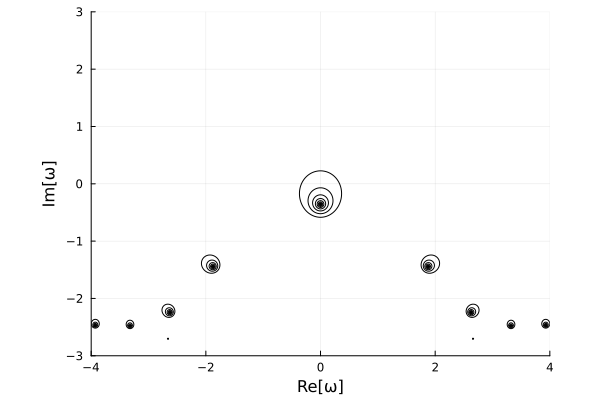

In [6]:
epsilon_real = reshape(real.(tabIminusXi),nEta,nOmega)
epsilon_imag = reshape(imag.(tabIminusXi),nEta,nOmega)
epsilon = abs.(epsilon_real .+ im * epsilon_imag)

using Plots
# Plot
contour(tabOmega,tabEta,log10.(epsilon), levels=10, color=:black, #levels=[-2.0, -1.5, -1.0, -0.5, -0.25, 0.0], 
        xlabel="Re[ω]", ylabel="Im[ω]", xlims=(-4, 4), ylims=(-3, 3),
        clims=(-2, 0), aspect_ratio=:equal, legend=false)


